In [1]:
from functools import partial
from json import dumps

import matplotlib.pyplot as plt
import numpy as np
import torch
import transformers
from tqdm.autonotebook import tqdm

import loader
from models import BinningCalibrator
import utils

split_ratio_test = 0.3
split_ratio_postproc = 0.2  # among all training data

# These seeds control the randomness for the post-process/test split and in
# postprocessing.  It does not affect pre-training data nor the randomness in
# pre-training, i.e., we assume the pre-trained predictor to be fixed.  Results
# will be aggregated over the seeds.
seeds = range(33, 38)

# This seed controls the randomness during pre-training (fixed)
seed_pretrain = 33

# Settings for calibration
n_bins_calib = 300
prior_strength_calib = 1
calibrator_factory = partial(BinningCalibrator,
                             n_bins=n_bins_calib,
                             prior_strength=prior_strength_calib)

max_workers = 1
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

data_dir = "data/biasbios"

In [2]:
## Download BiasBios dataset

(dataset, labels, label_names, groups,
 group_names) = loader.load_biasbios(data_dir, add_sensitive_attribute=True)
dataset_u = loader.load_biasbios(data_dir, add_sensitive_attribute=False)[0]
display(
    loader.dataset_stats(dataset['title'], label_names, dataset['gender'],
                         group_names))

n_classes = len(label_names)
n_groups = len(group_names)

print('example from attribute-aware dataset:',
      dumps(dataset[seed_pretrain], indent=2))
print('example from attribute-blind dataset:',
      dumps(dataset_u[seed_pretrain], indent=2))

Group,female,male
Target,,
accountant,2081,3571
architect,2398,7715
attorney,12494,20113
chiropractor,690,1908
comedian,592,2207
composer,918,4682
dentist,5153,9326
dietitian,3689,289
dj,211,1274


example from attribute-aware dataset: {
  "bio": "Male. He produced scores of films including such as al-Dhareeh (the shrine), 1976, winner of the Cinema Institute Films\u2019 Award at the Documentary and Short Films Festival, Egypt, 1977; as well as the Kelibia Festival Award, Tunisia, 1978; al-Mahatta (The Station), winner of a major award at Oberhausen Short Film Festival, Germany, 1989; the EU Award at FESPACO Festival, Burkina Faso, 1990; The Silver Sword Award at Damascus festival, 1990; and The Silver Tanit Award, Carthage festival, Tunisia, 1991. Eltayeb has served as head of the Sudanese Film group for several terms and as secretary of the Sudanese Film club. He has written numerous articles on cinema, published in major Sudanese newspapers. He is currently working on a long fiction film, al-Siraj wal-attama (The Lantern and Darkness).",
  "title": 9,
  "gender": 1
}
example from attribute-blind dataset: {
  "bio": "He produced scores of films including such as al-Dhareeh (the

In [3]:
## Split data into (test + post-processing) and pre-training sets

split_dataset = dataset.train_test_split(
    test_size=(1 - split_ratio_test) * (1 - split_ratio_postproc),
    seed=seed_pretrain,
)
dataset_ = split_dataset['train']
dataset_pretrain = split_dataset['test']

# Encode the joint (A, Y) labels by flattening
dataset_u = dataset_u.add_column(
    'labels_ay',
    np.array(dataset_u['gender']) * n_classes + np.array(dataset_u['title']))

split_dataset_u = dataset_u.train_test_split(
    test_size=(1 - split_ratio_test) * (1 - split_ratio_postproc),
    seed=seed_pretrain,
)
dataset_u_ = split_dataset_u['train']
dataset_pretrain_u = split_dataset_u['test']

labels_ = np.array(dataset_['title'])
groups_ = np.array(dataset_['gender'])

n_samples = len(dataset)
n_test = int(n_samples * split_ratio_test)

## BERT model

In [4]:
model_name = "bert-base-uncased"

In [5]:
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)


def tokenize_function(examples):
  tokenized_examples = tokenizer(examples["bio"],
                                 padding=False,
                                 max_length=tokenizer.model_max_length,
                                 truncation=True)
  return tokenized_examples


tokenized_dataset_ = dataset_.map(
    tokenize_function,
    batched=True,
    remove_columns=['bio'],
    desc="Running tokenizer",
)
tokenized_dataset_pretrain = dataset_pretrain.map(
    tokenize_function,
    batched=True,
    remove_columns=['bio'],
    desc="Running tokenizer",
)
tokenized_dataset_u_ = dataset_u_.map(
    tokenize_function,
    batched=True,
    remove_columns=['bio'],
    desc="Running tokenizer",
)
tokenized_dataset_pretrain_u = dataset_pretrain_u.map(
    tokenize_function,
    batched=True,
    remove_columns=['bio'],
    desc="Running tokenizer",
)

Running tokenizer:   0%|          | 0/173106 [00:00<?, ? examples/s]

Running tokenizer:   0%|          | 0/220317 [00:00<?, ? examples/s]

Running tokenizer:   0%|          | 0/173106 [00:00<?, ? examples/s]

Running tokenizer:   0%|          | 0/220317 [00:00<?, ? examples/s]

In [6]:
data_collator = transformers.DataCollatorWithPadding(tokenizer)


def train(model, dataset_train, dataset_test, label_col_name, batch_size,
          n_epochs, lr, warmup_ratio, weight_decay, max_grad_norm):

  dataloader_train = torch.utils.data.DataLoader(
      dataset_train,
      shuffle=True,
      collate_fn=data_collator,
      batch_size=batch_size,
  )
  dataloader_test = torch.utils.data.DataLoader(
      dataset_test,
      collate_fn=data_collator,
      batch_size=batch_size,
  )

  no_decay = ["bias", "LayerNorm.weight"]
  optimizer_grouped_parameters = [
      {
          "params": [
              p for n, p in model.named_parameters()
              if not any(nd in n for nd in no_decay)
          ],
          "weight_decay": weight_decay,
      },
      {
          "params": [
              p for n, p in model.named_parameters()
              if any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.0
      },
  ]
  optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=lr)
  scheduler = transformers.get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=(warmup_ratio * n_epochs * len(dataloader_train)),
      num_training_steps=n_epochs * len(dataloader_train))

  model_input_args = list(model.forward.__code__.co_varnames)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(n_epochs):

    model.train()
    for batch in tqdm(dataloader_train, desc=f"train epoch {epoch+1}"):
      batch = {k: v.to(device) for k, v in batch.items()}
      optimizer.zero_grad()
      outputs = model(**{
          k: v for k, v in batch.items() if k in model_input_args
      })
      loss = loss_fn(outputs.logits, batch[label_col_name])
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
      optimizer.step()
      scheduler.step()

    model.eval()
    with torch.no_grad():
      test_loss = 0
      test_acc = 0
      for batch in tqdm(dataloader_test, desc=f"test {epoch+1}"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**{
            k: v for k, v in batch.items() if k in model_input_args
        })
        probas = outputs.logits
        test_loss += loss_fn(probas, batch[label_col_name]).item()
        probas_y = probas.softmax(dim=1).reshape(len(batch['title']), -1,
                                                 n_classes).sum(dim=1)
        test_acc += (probas_y.argmax(dim=1) == batch['title']).sum().item()
      test_loss /= len(dataset_test['title'])
      test_acc /= len(dataset_test['title'])
      print(
          f"epoch {epoch+1}/{n_epochs}: loss={test_loss:.4f}, acc={test_acc:.4f}"
      )


def predict_probas(model, dataset, batch_size):
  dataloader = torch.utils.data.DataLoader(
      dataset,
      collate_fn=data_collator,
      batch_size=batch_size,
  )
  model_input_args = list(model.forward.__code__.co_varnames)
  model.eval()
  with torch.no_grad():
    probas = []
    for batch in tqdm(dataloader, desc="inference"):
      batch = {
          k: v.to(device) for k, v in batch.items() if k in model_input_args
      }
      outputs = model(**batch)
      probas.append(outputs.logits.softmax(dim=1).cpu().numpy())
    probas = np.concatenate(probas, axis=0)
    return probas

2024-10-29 03:46:36.837324: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 03:46:37.152953: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-10-29 03:46:38.863630: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Fine-tune BERT

In [7]:
## (Pre-)train predictors

batch_size = 32
n_epochs = 3
lr = 2e-5
warmup_ratio = 0.1
weight_decay = 0.01
max_grad_norm = 1.0

# Train attribute-aware p(Y | X) predictor
transformers.set_seed(seed_pretrain)
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=n_classes).to(device)
train(
    model,
    tokenized_dataset_pretrain,
    tokenized_dataset_.train_test_split(test_size=0.1,
                                        seed=seed_pretrain)['test'],
    'title',
    batch_size,
    n_epochs,
    lr,
    warmup_ratio,
    weight_decay,
    max_grad_norm,
)

# Train attribute-blind p(A, Y | X) predictor
transformers.set_seed(seed_pretrain)
model_u = transformers.AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=n_groups * n_classes).to(device)
train(
    model_u,
    tokenized_dataset_pretrain_u,
    tokenized_dataset_u_.train_test_split(test_size=0.1,
                                          seed=seed_pretrain)['test'],
    'labels_ay',
    batch_size,
    n_epochs,
    lr,
    warmup_ratio,
    weight_decay,
    max_grad_norm,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


train epoch 1:   0%|          | 0/6885 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


test 1:   0%|          | 0/541 [00:00<?, ?it/s]

epoch 1/3: loss=0.0151, acc=0.8572


train epoch 2:   0%|          | 0/6885 [00:00<?, ?it/s]

test 2:   0%|          | 0/541 [00:00<?, ?it/s]

epoch 2/3: loss=0.0149, acc=0.8619


train epoch 3:   0%|          | 0/6885 [00:00<?, ?it/s]

test 3:   0%|          | 0/541 [00:00<?, ?it/s]

epoch 3/3: loss=0.0153, acc=0.8659


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


train epoch 1:   0%|          | 0/6885 [00:00<?, ?it/s]

test 1:   0%|          | 0/541 [00:00<?, ?it/s]

epoch 1/3: loss=0.0159, acc=0.8515


train epoch 2:   0%|          | 0/6885 [00:00<?, ?it/s]

test 2:   0%|          | 0/541 [00:00<?, ?it/s]

epoch 2/3: loss=0.0151, acc=0.8610


train epoch 3:   0%|          | 0/6885 [00:00<?, ?it/s]

test 3:   0%|          | 0/541 [00:00<?, ?it/s]

epoch 3/3: loss=0.0154, acc=0.8637


## Post-processing

In [8]:
# Precompute P(A, Y | X) on (test + post-processing) set for aware setting
probas_y_ = predict_probas(model, tokenized_dataset_,
                           128).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predict_probas(model_u, tokenized_dataset_u_,
                              128).reshape(-1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'probas_ay': probas_ay_u_}

## Save post-processing arguments

# import os
# import pickle

# path = f'biasbios-{split_ratio_postproc}-kwargs.pkl'

# if not os.path.exists(path):
#   with open(path, 'wb') as f:
#     pickle.dump([postprocess_kwargs, postprocess_u_kwargs], f)
# else:
#   with open(path, 'rb') as f:
#     postprocess_kwargs, postprocess_u_kwargs = pickle.load(f)
#   probas_ay_ = postprocess_kwargs['probas_ay']
#   probas_ay_u_ = postprocess_u_kwargs['probas_ay']

inference:   0%|          | 0/1353 [00:00<?, ?it/s]

inference:   0%|          | 0/1353 [00:00<?, ?it/s]

In [9]:
print(
    'Binned ECE of attribute-blind predictor:',
    utils.calibration_error(probas_ay_u_.reshape(-1, n_groups * n_classes),
                            groups_ * n_classes + labels_,
                            n_bins=n_bins_calib))

Binned ECE of attribute-blind predictor: 0.8614519137283446


Code for post-processing a single model (with precomputed probas):

    postprocessor = postprocess.PostProcessor(
        n_classes,
        n_groups,
        pred_ay_fn=lambda x: x,  # dummy pred_fn
        criterion='sp',
        alpha=alpha,
        seed=seed,
    )
    postprocessor.fit(probas_ay_postproc)
    preds = postprocessor.predict(probas_ay_test)


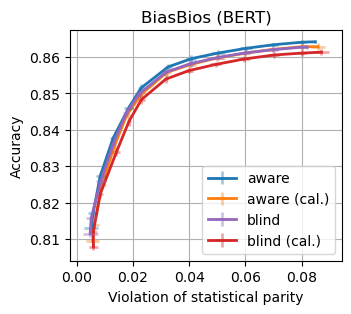

Results for attribute-aware setting:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.864203  0.000423  0.084765  0.000432     0.023368  0.000118
0.080  0.864086  0.000507  0.080105  0.001393     0.022853  0.000203
0.070  0.863388  0.000567  0.069939  0.001716     0.021732  0.000187
0.060  0.862395  0.000648  0.060197  0.001978     0.020733  0.000215
0.050  0.861103  0.000733  0.050215  0.002449     0.019802  0.000228
0.040  0.859560  0.000874  0.040757  0.001821     0.019022  0.000217
0.030  0.857294  0.000844  0.032499  0.001217     0.017663  0.000258
0.020  0.851538  0.001106  0.022942  0.001233     0.014060  0.000346
0.015  0.846108  0.000710  0.018542  0.001536     0.011326  0.000320
0.010  0.837744  0.000671  0.012982  0.001128     0.008083  0.000353
0.005  0.827240  0.000804  0.008366  0.001619     0.004866  0.000360
0.002  0.817259  0.000607  0.005898  0.001757     0.002585  0.000498
0.001  0.812956  0.000605  0.005175  0.002576     0.001907  0.000545

Results for attribute-aware setting with calibration:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.862851  0.000876  0.085746  0.002335     0.023375  0.000209
0.080  0.862845  0.000987  0.079918  0.001849     0.022712  0.000276
0.070  0.862124  0.000687  0.069898  0.001377     0.021743  0.000287
0.060  0.861054  0.000774  0.059793  0.001883     0.020655  0.000347
0.050  0.859778  0.000973  0.049975  0.002602     0.019889  0.000288
0.040  0.857947  0.001048  0.040447  0.001869     0.019035  0.000279
0.030  0.855806  0.000996  0.032112  0.001437     0.017397  0.000490
0.020  0.849745  0.001272  0.022949  0.000944     0.014097  0.000350
0.015  0.843980  0.000750  0.017782  0.001264     0.011353  0.000383
0.010  0.835413  0.001134  0.013385  0.001409     0.008210  0.000359
0.005  0.824749  0.001130  0.008908  0.001669     0.004993  0.000366
0.002  0.813873  0.001218  0.006305  0.001674     0.002613  0.000503
0.001  0.809469  0.001127  0.005733  0.002313     0.001961  0.000548

Results for attribute-blind setting:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.862781  0.000589  0.081805  0.000419     0.023292  0.000118
0.080  0.862722  0.000612  0.080126  0.001245     0.023108  0.000174
0.070  0.862035  0.000669  0.069906  0.001584     0.022013  0.000135
0.060  0.861146  0.000678  0.059970  0.001725     0.020998  0.000165
0.050  0.859872  0.000781  0.050112  0.001875     0.020085  0.000133
0.040  0.858194  0.000860  0.040490  0.001168     0.019305  0.000210
0.030  0.855840  0.000994  0.031732  0.000798     0.017809  0.000246
0.020  0.849848  0.000923  0.022172  0.001091     0.013955  0.000337
0.015  0.844592  0.000934  0.017631  0.001032     0.011225  0.000405
0.010  0.836128  0.000771  0.013018  0.001005     0.008049  0.000371
0.005  0.825925  0.000682  0.008582  0.001734     0.004835  0.000391
0.002  0.815788  0.000752  0.005186  0.001888     0.002528  0.000475
0.001  0.811509  0.000875  0.004811  0.002682     0.001929  0.000554

Results for attribute-blind setting with calibration:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.861347  0.000798  0.086983  0.002755     0.023638  0.000365
0.080  0.861092  0.000778  0.080068  0.001461     0.022886  0.000335
0.070  0.860561  0.000868  0.070020  0.001959     0.021876  0.000275
0.060  0.859446  0.000934  0.059367  0.002181     0.020864  0.000340
0.050  0.857963  0.000811  0.049343  0.001829     0.019966  0.000266
0.040  0.856262  0.000757  0.039827  0.001459     0.019223  0.000244
0.030  0.853925  0.001056  0.031668  0.000666     0.017693  0.000283
0.020  0.848298  0.001283  0.023021  0.001113     0.014245  0.000274
0.015  0.842348  0.001183  0.018605  0.000869     0.011343  0.000299
0.010  0.833779  0.000863  0.014075  0.001476     0.008153  0.000326
0.005  0.822431  0.001198  0.008415  0.001052     0.004809  0.000288
0.002  0.811950  0.001076  0.005879  0.001518     0.002489  0.000364
0.001  0.807856  0.000928  0.005976  0.001711     0.001936  0.000383

In [10]:
## Post-processing for statistical parity

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.015, 0.01, 0.005,
        0.002, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    print_code=True,
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.015, 0.01, 0.005,
        0.002, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.015, 0.01, 0.005,
        0.002, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.015, 0.01, 0.005,
        0.002, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_sp',
                   'accuracy',
                   label='aware',
                   zorder=20)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_sp',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=10)
utils.plot_results(ax,
                   df_blind,
                   'delta_sp',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_sp',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("BiasBios (BERT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)

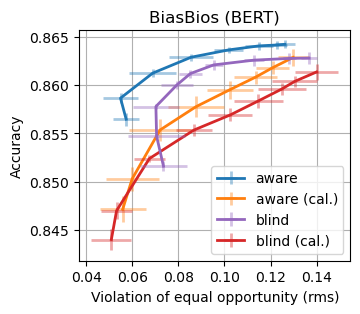

Results for attribute-aware setting:


accuracy           delta_eopp           delta_eopp_rms            \
           mean       std       mean       std           mean       std   
alpha                                                                     
inf    0.864203  0.000423   0.379256  0.011598       0.126185  0.004296   
0.250  0.864133  0.000432   0.351912  0.020903       0.122787  0.004316   
0.200  0.864040  0.000398   0.316298  0.028819       0.114989  0.005958   
0.150  0.863625  0.000335   0.268320  0.019055       0.101809  0.006281   
0.100  0.862871  0.000365   0.220856  0.013864       0.085549  0.009481   
0.050  0.861225  0.000419   0.187370  0.012737       0.068826  0.010102   
0.010  0.858645  0.000521   0.161046  0.026770       0.054860  0.007556   
0.001  0.856479  0.000672   0.167732  0.017194       0.057303  0.005586   

       delta_eo           delta_eo_rms            
           mean       std         mean       std  
alpha                                             
inf    0.379256  0.011598     0.029199  0.000941  
0.250  0.351912  0.020903     0.028561  0.000941  
0.200  0.316298  0.028819     0.026996  0.001337  
0.150  0.268320  0.019055     0.024337  0.001306  
0.100  0.220856  0.013864     0.021328  0.002023  
0.050  0.187954  0.012485     0.018018  0.001936  
0.010  0.161175  0.027023     0.015870  0.001295  
0.001  0.175037  0.019541     0.018574  0.001311

Results for attribute-aware setting with calibration:


accuracy           delta_eopp           delta_eopp_rms            \
           mean       std       mean       std           mean       std   
alpha                                                                     
inf    0.862851  0.000876   0.373361  0.014683       0.129863  0.006741   
0.250  0.861788  0.000646   0.309888  0.041726       0.120917  0.007239   
0.200  0.860819  0.000667   0.287426  0.039038       0.113555  0.009319   
0.150  0.859521  0.000933   0.255000  0.034723       0.102385  0.010181   
0.100  0.857758  0.001110   0.229947  0.031775       0.087604  0.012048   
0.050  0.855354  0.001146   0.212756  0.032658       0.072016  0.013592   
0.010  0.850314  0.001243   0.191019  0.036429       0.059928  0.011512   
0.001  0.847176  0.001350   0.170092  0.019268       0.055801  0.010059   

       delta_eo           delta_eo_rms            
           mean       std         mean       std  
alpha                                             
inf    0.373361  0.014683     0.030651  0.001537  
0.250  0.309888  0.041726     0.028932  0.001518  
0.200  0.287426  0.039038     0.027730  0.002161  
0.150  0.255000  0.034723     0.025719  0.002032  
0.100  0.238454  0.030443     0.023423  0.001623  
0.050  0.219269  0.031338     0.020843  0.001865  
0.010  0.220647  0.037865     0.021018  0.002244  
0.001  0.234936  0.031988     0.021536  0.001669

Results for attribute-blind setting:


accuracy           delta_eopp           delta_eopp_rms            \
           mean       std       mean       std           mean       std   
alpha                                                                     
inf    0.862781  0.000589   0.410378  0.016398       0.136717  0.003302   
0.300  0.862747  0.000603   0.372171  0.031028       0.128193  0.002688   
0.250  0.862571  0.000558   0.327095  0.018526       0.112902  0.004429   
0.200  0.862078  0.000498   0.263823  0.013498       0.095336  0.003902   
0.150  0.861185  0.000412   0.227323  0.016146       0.085219  0.005139   
0.100  0.859997  0.000447   0.199096  0.016381       0.079282  0.006916   
0.050  0.857780  0.000289   0.207902  0.061864       0.070228  0.010028   
0.010  0.854724  0.000221   0.238334  0.081377       0.070528  0.012527   
0.001  0.851621  0.000526   0.253206  0.074771       0.073520  0.010225   

       delta_eo           delta_eo_rms            
           mean       std         mean       std  
alpha                                             
inf    0.410378  0.016398     0.031611  0.000742  
0.300  0.372171  0.031028     0.029806  0.000734  
0.250  0.327095  0.018526     0.026287  0.000915  
0.200  0.263823  0.013498     0.022921  0.000608  
0.150  0.227323  0.016146     0.021351  0.000652  
0.100  0.199096  0.016381     0.020564  0.000924  
0.050  0.209183  0.059639     0.019163  0.001540  
0.010  0.238334  0.081377     0.019954  0.002073  
0.001  0.265272  0.055966     0.021644  0.001424

Results for attribute-blind setting with calibration:


accuracy           delta_eopp           delta_eopp_rms            \
           mean       std       mean       std           mean       std   
alpha                                                                     
inf    0.861347  0.000798   0.414568  0.014768       0.139991  0.009344   
0.300  0.860382  0.000592   0.357006  0.033172       0.130574  0.009805   
0.250  0.859580  0.000651   0.330447  0.027307       0.124852  0.010446   
0.200  0.858348  0.000768   0.288524  0.036559       0.114630  0.010612   
0.150  0.856916  0.000661   0.253823  0.049569       0.102560  0.009535   
0.100  0.855351  0.000608   0.204694  0.040941       0.086736  0.007874   
0.050  0.852407  0.000404   0.171066  0.043034       0.067401  0.006673   
0.010  0.847027  0.000855   0.143210  0.024592       0.053153  0.006809   
0.001  0.844050  0.001106   0.137167  0.027265       0.050881  0.008627   

       delta_eo           delta_eo_rms            
           mean       std         mean       std  
alpha                                             
inf    0.414568  0.014768     0.032792  0.002318  
0.300  0.357006  0.033172     0.030905  0.002254  
0.250  0.330447  0.027307     0.029868  0.002454  
0.200  0.288524  0.036559     0.028210  0.002462  
0.150  0.253823  0.049569     0.026222  0.001960  
0.100  0.206054  0.038976     0.023590  0.001296  
0.050  0.184193  0.034666     0.020087  0.001011  
0.010  0.193446  0.025305     0.020545  0.001579  
0.001  0.238700  0.032253     0.021956  0.001200

In [11]:
## Post-processing for equal opportunity

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms', 'delta_eo', 'delta_eo_rms'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms', 'delta_eo', 'delta_eo_rms'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms', 'delta_eo', 'delta_eo_rms'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms', 'delta_eo', 'delta_eo_rms'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_eopp_rms',
                   'accuracy',
                   label='aware',
                   zorder=20)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_eopp_rms',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=10)
utils.plot_results(ax,
                   df_blind,
                   'delta_eopp_rms',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_eopp_rms',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of equal opportunity (rms)")
ax.set_ylabel("Accuracy")
ax.set_title("BiasBios (BERT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)

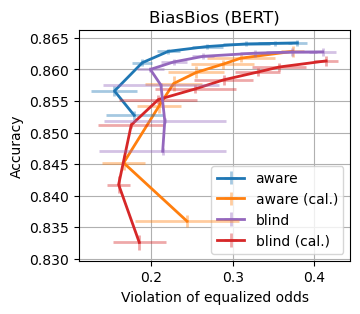

Results for attribute-aware setting:


accuracy           delta_eopp           delta_eopp_rms            \
           mean       std       mean       std           mean       std   
alpha                                                                     
inf    0.864203  0.000423   0.379256  0.011598       0.126185  0.004296   
0.250  0.864133  0.000432   0.351912  0.020903       0.122787  0.004316   
0.200  0.864040  0.000398   0.316298  0.028819       0.114989  0.005958   
0.150  0.863625  0.000335   0.268320  0.019055       0.101809  0.006281   
0.100  0.862871  0.000365   0.220856  0.013864       0.085549  0.009481   
0.050  0.861059  0.000512   0.188631  0.012372       0.068724  0.009990   
0.010  0.856586  0.000793   0.154506  0.028250       0.054833  0.007167   
0.001  0.852736  0.000700   0.178692  0.034922       0.057906  0.003847   

       delta_eo           delta_eo_rms            
           mean       std         mean       std  
alpha                                             
inf    0.379256  0.011598     0.029199  0.000941  
0.250  0.351912  0.020903     0.028561  0.000941  
0.200  0.316298  0.028819     0.026996  0.001337  
0.150  0.268320  0.019055     0.024337  0.001306  
0.100  0.220856  0.013864     0.021328  0.002023  
0.050  0.188631  0.012372     0.018056  0.001916  
0.010  0.154506  0.028250     0.014931  0.001342  
0.001  0.178692  0.034922     0.015304  0.000674

Results for attribute-aware setting with calibration:


accuracy           delta_eopp           delta_eopp_rms            \
           mean       std       mean       std           mean       std   
alpha                                                                     
inf    0.862851  0.000876   0.373361  0.014683       0.129863  0.006741   
0.250  0.861785  0.000645   0.309888  0.041726       0.120915  0.007238   
0.200  0.860812  0.000667   0.287426  0.039038       0.112427  0.009095   
0.150  0.859521  0.000943   0.255000  0.034723       0.100358  0.010330   
0.100  0.857762  0.001161   0.227150  0.034679       0.084643  0.012748   
0.050  0.854190  0.001105   0.209221  0.027229       0.068556  0.011916   
0.010  0.845199  0.001198   0.165753  0.026293       0.059387  0.008302   
0.001  0.835958  0.000970   0.243615  0.063917       0.076292  0.009684   

       delta_eo           delta_eo_rms            
           mean       std         mean       std  
alpha                                             
inf    0.373361  0.014683     0.030651  0.001537  
0.250  0.309888  0.041726     0.028931  0.001517  
0.200  0.287426  0.039038     0.027441  0.002004  
0.150  0.255000  0.034723     0.025088  0.002214  
0.100  0.227150  0.034679     0.022228  0.002399  
0.050  0.209221  0.027229     0.018473  0.002116  
0.010  0.165753  0.026293     0.016261  0.001368  
0.001  0.243615  0.063917     0.019243  0.001437

Results for attribute-blind setting:


accuracy           delta_eopp           delta_eopp_rms            \
           mean       std       mean       std           mean       std   
alpha                                                                     
inf    0.862781  0.000589   0.410378  0.016398       0.136717  0.003302   
0.300  0.862747  0.000603   0.372171  0.031028       0.128193  0.002688   
0.250  0.862571  0.000558   0.327095  0.018526       0.112902  0.004429   
0.200  0.862078  0.000498   0.263823  0.013498       0.095336  0.003902   
0.150  0.861185  0.000412   0.227323  0.016146       0.085219  0.005139   
0.100  0.860000  0.000453   0.198587  0.016225       0.079247  0.006919   
0.050  0.857511  0.000310   0.211591  0.070874       0.071005  0.012767   
0.010  0.851846  0.000384   0.216346  0.074688       0.066605  0.012756   
0.001  0.847039  0.000531   0.213767  0.078427       0.068539  0.012884   

       delta_eo           delta_eo_rms            
           mean       std         mean       std  
alpha                                             
inf    0.410378  0.016398     0.031611  0.000742  
0.300  0.372171  0.031028     0.029806  0.000734  
0.250  0.327095  0.018526     0.026287  0.000915  
0.200  0.263823  0.013498     0.022921  0.000608  
0.150  0.227323  0.016146     0.021351  0.000652  
0.100  0.198587  0.016225     0.020541  0.000921  
0.050  0.211591  0.070874     0.018490  0.002126  
0.010  0.216346  0.074688     0.016643  0.002331  
0.001  0.213767  0.078427     0.016596  0.002322

Results for attribute-blind setting with calibration:


accuracy           delta_eopp           delta_eopp_rms            \
           mean       std       mean       std           mean       std   
alpha                                                                     
inf    0.861347  0.000798   0.414568  0.014768       0.139991  0.009344   
0.300  0.860382  0.000592   0.357006  0.033172       0.130574  0.009805   
0.250  0.859580  0.000651   0.330447  0.027307       0.124852  0.010446   
0.200  0.858341  0.000784   0.288524  0.036559       0.114579  0.010642   
0.150  0.856911  0.000653   0.253823  0.049569       0.102045  0.009023   
0.100  0.855230  0.000705   0.208488  0.047947       0.084038  0.008536   
0.050  0.851192  0.000482   0.175151  0.040681       0.064383  0.007948   
0.010  0.841754  0.001357   0.159615  0.014260       0.059016  0.009349   
0.001  0.832589  0.001236   0.184990  0.032533       0.066455  0.010001   

       delta_eo           delta_eo_rms            
           mean       std         mean       std  
alpha                                             
inf    0.414568  0.014768     0.032792  0.002318  
0.300  0.357006  0.033172     0.030905  0.002254  
0.250  0.330447  0.027307     0.029868  0.002454  
0.200  0.288524  0.036559     0.028179  0.002460  
0.150  0.253823  0.049569     0.026053  0.001891  
0.100  0.208488  0.047947     0.022578  0.001337  
0.050  0.175151  0.040681     0.018516  0.000831  
0.010  0.159615  0.014260     0.016472  0.001216  
0.001  0.184990  0.032533     0.017896  0.001522

In [12]:
## Post-processing for equalized odds

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms', 'delta_eo', 'delta_eo_rms'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms', 'delta_eo', 'delta_eo_rms'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms', 'delta_eo', 'delta_eo_rms'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms', 'delta_eo', 'delta_eo_rms'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_eo',
                   'accuracy',
                   label='aware',
                   zorder=20)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_eo',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=10)
utils.plot_results(ax,
                   df_blind,
                   'delta_eo',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_eo',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("BiasBios (BERT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)